In [ ]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.model_selection import KFold

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML
from datetime import datetime
from langdetect import detect
import re
import copy

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7

In [5]:
VAL_FRACTION = 0.25

In [6]:
MIN_COMMENT_LEN = 25

In [7]:
TOP_N = 5

In [8]:
MODEL_NAME = "https://tfhub.dev/google/nnlm-en-dim50/2"

## GET DATA

In [9]:
def get_hot_data():
    hot = requests.get("https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame").content.decode()
  
    # Parsing the XML file
    xmlparse = Xet.fromstring(hot)

    hot_array = []
    for item in xmlparse:
        dict_element = {
            "id": item.get("id"),
            "rank": item.get("rank")
        }
        for option in item:
            dict_element[option.tag] = option.get("value")
        hot_array.append(dict_element)
    return hot_array

In [10]:
def get_comments(id_array, verbose=1):
    max_comments_per_page = 1
    array_ids = [h['id'] for h in id_array]
    ids = ','.join(array_ids)
    page_size = 100
    page_number = 0
    comments_array = []

    while max_comments_per_page > 0 and len(array_ids) > 0:
        page_number += 1
        if verbose>0 and page_number%verbose==0:
            print(f"page number = {page_number}", end=" ")
        comments = requests.get(f"https://www.boardgamegeek.com/xmlapi2/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

        # Parsing the XML file
        xmlparse = Xet.fromstring(comments)
        comments_per_item = []
        for item in xmlparse:        
            for option in item:
                if option.tag == 'comments':
                    comments_per_page = 0
                    for comment in option:
                        comments_per_page += 1
                        dict_element = {
                            "id": item.get("id"),
                            "username": comment.get("username"),
                            "rating": comment.get("rating"),
                            "value": comment.get("value")
                        }
                        comments_array.append(dict_element)
                    if comments_per_page==0:
                        array_ids.remove(item.get("id"))
                        ids = ','.join(array_ids)
                    comments_per_item.append(comments_per_page)
        max_comments_per_page = max(comments_per_item)
        if verbose>0 and page_number%verbose==0:
            print(f"(max: {max(comments_per_item)}, len: {len(comments_per_item)})")
    comments_df = pd.DataFrame(comments_array)
    print(f"comments_df shape: {comments_df.shape}")
    return comments_df

In [11]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '285192',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/oaD1ZQ3yGj6lacLdtqgdnQ__thumb/img/1mCz7HPEFMeqaqJHsDZwEUc9ftw=/fit-in/200x150/filters:strip_icc()/pic5558118.png',
  'name': 'Destinies',
  'yearpublished': '2021'},
 {'id': '331106',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/tQVVSXcmYLvAoI28cp-2Tg__thumb/img/ahKWaUSws5zja4feB4VexkNV3Mc=/fit-in/200x150/filters:strip_icc()/pic5974859.jpg',
  'name': 'The Witcher: Old World',
  'yearpublished': '2022'}]

In [12]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

missing csv file, getting new data using API...
page number = 10 (max: 100, len: 26)
page number = 20 (max: 100, len: 18)
page number = 30 (max: 100, len: 14)
page number = 40 (max: 100, len: 11)
page number = 50 (max: 100, len: 6)
page number = 60 (max: 100, len: 5)
page number = 70 (max: 100, len: 4)
page number = 80 (max: 100, len: 4)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 0, len: 1)
comments_df shape: (107725, 4)


,id,username,rating,value
0,285192,Alarka,8.5,Players: 1-3 (1-2) Time: 90-150 Min Category: ...
1,285192,almi,N/A,2021-05
2,285192,androgeus,N/A,soll Ende Mai 21 lieferbar sein
3,285192,AnneWit,9,"On first play, this is another outstanding gam..."
4,285192,ArmyLee,N/A,KS Ed. - Sea of Sand - Myth & Folklore crossover
...,...,...,...,...
107720,167791,z_zadar,9,Some games are so much fun. Others can be a li...
107721,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
107722,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
107723,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [13]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  

In [14]:
comments_df["value"] = comments_df["value"].astype(str)

In [15]:
# REMOVE URLs FROM COMMENTS

In [16]:
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]

In [17]:
# REMOVE SHORT COMMENTS
def remove_short_comments(df: pd.DataFrame, min_len=25, method='unrated'):
    if method not in ['unrated', 'rated', 'both']:
        raise AttributeError(f"method {method} not allowed")
    df_local = df.copy()    
    df_local['comment_len'] = [len(re.findall("[A-Za-z]", v)) for v in df_local['value'].values]
    if method == 'rated':
        df_local = df_local.query('(comment_len>@min_len and rating != "N/A") or rating == "N/A"')
    elif method == 'unrated':
        df_local = df_local.query('(comment_len>@min_len and rating == "N/A") or rating != "N/A"')
    else:
        df_local = df_local.query('comment_len>@min_len')
    print(f"removed {len(df)-len(df_local)} for 'remove_short_comments' - min len: {min_len} - method: {method}")
    return df_local.reset_index(drop=True)

In [18]:
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 17503 for 'remove_short_comments' - min len: 25 - method: unrated


In [19]:
# REMOVE NON ENGLISH COMMENTS

In [20]:
# !conda install -c conda-forge langdetect

In [21]:
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)

In [22]:
# comments_df = add_comments_lang(comments_df)

In [23]:
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [24]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

9        16904
10       16242
8        15135
7         8280
N/A       7346
         ...  
9.964        1
9.954        1
4.66         1
6.446        1
9.94         1
Name: rating, Length: 574, dtype: int64

In [25]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(82876, 5)

In [26]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(7346, 5)

## CREATE TRAINING AND VALIDATION DATA

In [27]:
# use rated comments (reviews) to train the model

In [28]:
rated_comments = rated_comments.sample(frac=1)

In [29]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [30]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


"Absolutely incredible.  Played several games over the release weekend and woke up on Monday wanting to play more.  That's the sign of a game that will be an exciting part of my collection for a long time."

In [31]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


"Played a 2-player game at Origins 2018.  I liked the mechanics but for 2 people there wasn't enough forced overlap to really make it fun.  I would guess at 4 players this could be really good."

## COMPOSE MODEL

In [32]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

In [33]:
def build_model(hub_layer=None, model_type='classifier', lstm=False, verbose=1):    
    if hub_layer is None:
        hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)
        
    if model_type not in ('classifier', 'regressor'):
        raise AttributeError("model type can only be 'classifier' or 'regressor'")

    if verbose:
        print("example of layers processing:")
        print(hub_layer(train_examples[:2]))
        print("")

    if model_type == 'classifier':
        model = tf.keras.Sequential()
        model.add(copy.copy(hub_layer))
        if lstm:
            raise NotImplementedError("lstm = True is not implemented")
        else:
            model.add(tf.keras.layers.Dense(16, activation='relu'))
        model.add(tf.keras.layers.Dense(1))
        
        if verbose:
            print("model summary:")
            print(model.summary())
        
        model.compile(
            optimizer='adam',
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
        )
    else:
        model = tf.keras.Sequential()
        model.add(copy.copy(hub_layer))
        if lstm:
            raise NotImplementedError("lstm = True is not implemented")
        else:
            model.add(tf.keras.layers.Dense(16, activation='relu', kernel_initializer='normal'))
        model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))
        
        if verbose:
            print("model summary:")
            print(model.summary())
            
        model.compile(
            loss='mean_squared_error', 
            optimizer='adam',
            metrics=["mean_squared_error"]
        )
    
    return model

## CLASSIFIER

In [34]:
def build_classifier():
    return build_model(hub_layer=None, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=512, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
81/81 - 6s - loss: 0.4973 - accuracy: 0.8427 - val_loss: 0.4178 - val_accuracy: 0.8517
Epoch 2/100
81/81 - 4s - loss: 0.3540 - accuracy: 0.8678 - val_loss: 0.3354 - val_accuracy: 0.8688
Epoch 3/100
81/81 - 4s - loss: 0.2836 - accuracy: 0.8891 - val_loss: 0.3135 - val_accuracy: 0.8754
Epoch 4/100
81/81 - 4s - loss: 0.2417 - accuracy: 0.9046 - val_loss: 0.3117 - val_accuracy: 0.8777
Epoch 5/100
81/81 - 4s - loss: 0.2104 - accuracy: 0.9185 - val_loss: 0.3201 - val_accuracy: 0.8762
Epoch 6/100
81/81 - 4s - loss: 0.1851 - accuracy: 0.9296 - val_loss: 0.3343 - val_accuracy: 0.8711
Epoch 7/100
81/81 - 4s - loss: 0.1647 - accuracy: 0.9386 - val_loss: 0.3547 - val_accuracy: 0.8676
Epoch 8/100
81/81 - 4s - loss: 0.1472 - accuracy: 0.9456 - val_loss: 0.3775 - val_accuracy: 0.8641
Epoch 9/100
81/81 - 4s - loss: 0.1332 - accuracy: 0.9529 - val_loss: 0.4046 - val_accuracy: 0.8584
54/54 - 0s - loss: 0.4170 - accuracy: 0.8573
Epoch 1/100
81/81 - 5s - loss: 0.4620 - accuracy: 0.8516 - val_l

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000020110D25A30>,
             param_grid={})

In [35]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [36]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [38]:
epochs = range(1, len(acc) + 1) 

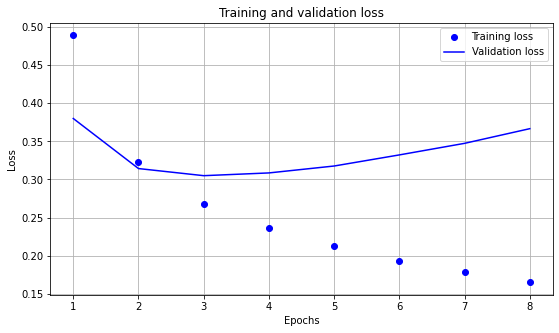

In [39]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

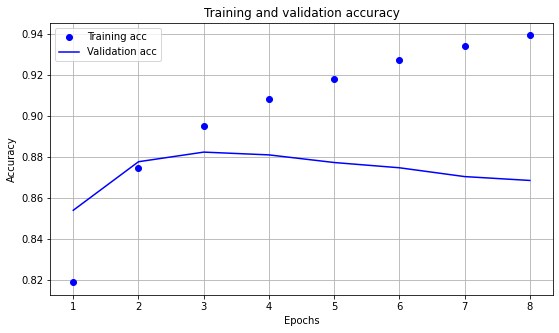

In [40]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [41]:
def print_my_examples(inputs, results, actual_values=None, limit=None):
    if actual_values is None:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}' for i in range(len(inputs))]
    else:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}\nactual value:{actual_values[i]}' for i in range(len(inputs))]
    if limit:
        result_for_printing = result_for_printing[:limit]
    print(*result_for_printing, sep='\n\n')

In [42]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"Absolutely incredible.  Played several games over the release weekend and woke up on Monday wanting to play more.  That's the sign of a game that will be an exciting part of my collection for a long time."
score: 1.000000
actual value:1

input:
"My only criticism is that it drags with 4 players."
score: 1.000000
actual value:1

input:
"Have Tabletopia and Table Top Simulator version and First Edition Print.  Rating after 3 x Tabletopia games & 3 person to person 3&5 player games."
score: 1.000000
actual value:1

input:
"Difficult to master, but very enjoyable when in a not so competitive mood"
score: 1.000000
actual value:1

input:
"Completely lived up to the hype for me. I have only gotten to play it a handful of times so far, mainly because I work a lot, but I had a blast. The game hits all the buttons that I love about games; it looks great, the system is nicely done with a level of skill required to play, there is a lot or replay value, there is character progression and un

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [43]:
## APPLY MODEL ON NON-RATED COMMENTS

In [44]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

15/15 - 0s
input:
"Brand new and Sleeved.  Love this little game."
score: 1.000000

input:
"Premium rebel 63.5x89 (odrobinę za dlugie) ,sloyca premium 44x68"
score: 1.000000

input:
"Need to learn the rules Sleeved, Arcane Tinmen"
score: 1.000000

input:
"[b]Negative points[/b]: • Insert is cheap and brittle.  ----  [b]Initial Impression[/b] (3p): Neutral  To be fair it's probably because of how overwhelming the game can be and not being able to understand how everything connects until almost the very end. (We won but it didn't feel as satisfying - maybe it was too easy?) Box insert seems to be made of cheap plastic and arrived partially shattered. Feels like Pandemic on steroids which is a good thing. Rulebook could have been structured a bit better. Felt weird playing this on the eve of Australia Day."
score: 1.000000

input:
"This may just be the most gorgeous game I have ever seen"
score: 1.000000

input:
"Need to play more, but I made some super awesome Tikis out of polymer clay t

## REGRESSOR

In [45]:
def build_regressor():
    return build_model(hub_layer, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x00000203D9FED490>,
             param_grid={})

In [46]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [47]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [48]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [49]:
epochs = range(1, len(mean_squared_error) + 1) 

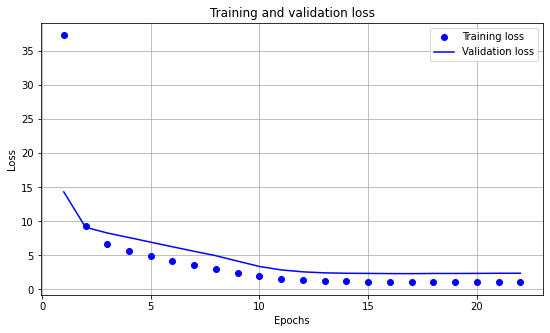

In [50]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

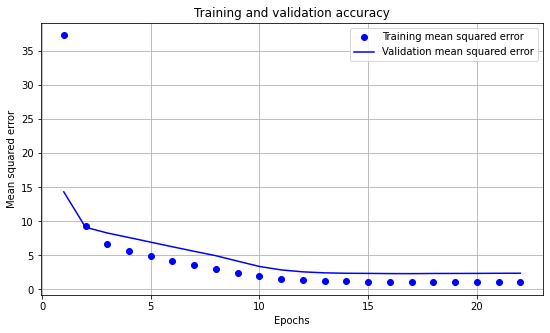

In [51]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [52]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"Absolutely incredible.  Played several games over the release weekend and woke up on Monday wanting to play more.  That's the sign of a game that will be an exciting part of my collection for a long time."
score: 9.25
actual: 10.00 

input: 
"My only criticism is that it drags with 4 players."
score: 8.40
actual: 8.00 

input: 
"Have Tabletopia and Table Top Simulator version and First Edition Print.  Rating after 3 x Tabletopia games & 3 person to person 3&5 player games."
score: 8.19
actual: 8.50 

input: 
"Difficult to master, but very enjoyable when in a not so competitive mood"
score: 7.31
actual: 9.00 

input: 
"Completely lived up to the hype for me. I have only gotten to play it a handful of times so far, mainly because I work a lot, but I had a blast. The game hits all the buttons that I love about games; it looks great, the system is nicely done with a level of skill required to play, there is a lot or replay value, there is character progression and uniqueness to it

## COMPARE CLASSIFIER VS REGRESSOR

In [53]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"1-6 Players // Best 3 // 40-80 min // All Expansions"
    reg score: 8.36
    clf score: 1

"Nice components and mechanisms resource management, upgrades, variability, but at the end of the game not fun for me and I don't enjoy playing it."
    reg score: 6.92
    clf score: 0

"Gekauft bei spieletastisch ca.30,95 €"
    reg score: 2.81
    clf score: 0

"Christmas present to self December 2020"
    reg score: 7.37
    clf score: 1

"Kickstarter exclusive?  Best with 4 players, a lot to manage solitaire (solo)"
    reg score: 8.67
    clf score: 1

"Pantheon and all promo wonders"
    reg score: 8.20
    clf score: 1

"pre-ordered  on recent Kickstarter campaign"
    reg score: 9.92
    clf score: 1

"Card Sleeves: Standard - Ultra Pro 81126 (Penny Sleeves)"
    reg score: 9.47
    clf score: 1

"Unboxing:   Tutorial:   Aquí una partida:   Aquí una partida: "
    reg score: 7.35
    clf score: 1

"Forschungs Wettlauf zu den Sternen. Deutsche Version von Strohmann Games geplant. Ohne D

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [54]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 124361 |          8.18 |           3845 |
| 128721 |          7.62 |            249 |
| 162886 |          8.35 |           3519 |
| 167355 |          8.42 |           1812 |
| 167791 |          8.21 |           8244 |


In [69]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [70]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 124361 |          7.97 |            256 |
| 128721 |          8.27 |             50 |
| 162886 |          8.10 |            312 |
| 167355 |          8.28 |            214 |
| 167791 |          8.14 |            440 |


In [71]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [72]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/oaD1ZQ3...","<a href=""https://boardgamegeek.com/boardgame/2...",8.307619,7.979925,8.227464,1,2021
1,"<img src=""https://cf.geekdo-images.com/tQVVSXc...","<a href=""https://boardgamegeek.com/boardgame/3...",7.531250,8.468117,7.868522,2,2022
2,"<img src=""https://cf.geekdo-images.com/KTKXgGG...","<a href=""https://boardgamegeek.com/boardgame/3...",10.000000,5.841890,7.920945,3,2021
3,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.857066,7.838713,7.855444,4,2020
4,"<img src=""https://cf.geekdo-images.com/A7IOpPt...","<a href=""https://boardgamegeek.com/boardgame/2...",7.357140,7.892917,7.398420,5,2017


In [73]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [74]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Destinies,8.307619,7.979925,8.227464,1,2021
2,,The Witcher: Old World,7.531250,8.468117,7.868522,2,2022
3,,The Goonies: Never Say Die,10.000000,5.841890,7.920945,3,2021
4,,Lost Ruins of Arnak,7.857066,7.838713,7.855444,4,2020
5,,Fantasy Realms,7.357140,7.892917,7.398420,5,2017


In [75]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,The Goonies: Never Say Die,10.000000,5.841890,7.920945,3,2021
2,,Chronicles of Drunagor: Age of Darkness,9.309524,8.841975,9.256842,43,2021
3,,Eclipse: Second Dawn for the Galaxy,8.742227,7.888690,8.608913,49,2020
4,,Brass: Birmingham,8.682122,8.112962,8.630462,23,2018
5,,Middara: Unintentional Malum – Act 1,8.612134,8.246915,8.523596,45,2019


In [76]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Chronicles of Drunagor: Age of Darkness,9.309524,8.841975,9.256842,43,2021
2,,Paperback Adventures,8.400000,9.370757,8.764034,12,2021
3,,Lost Ruins of Arnak: The Search for Professor Kutil,8.500000,9.088474,8.696158,11,2021
4,,Brass: Birmingham,8.682122,8.112962,8.630462,23,2018
5,,Eclipse: Second Dawn for the Galaxy,8.742227,7.888690,8.608913,49,2020


In [77]:
# model.save('saved_model\my_model')

In [78]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [79]:
# some examples on "long" comments vs short comments

In [80]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [81]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"Would take in trade if complete, that is, no legacy aspects have been done, rendering it otherwise useless... unsure about this title though. "
score: 2.70

"2. Grundspiel, um: - Alle Karten oft genug zu haben, damit sie beliebig verwendet werden können (also jede nicht-Szenario-Deckbau-Karte jeweils mindestens 2x). - Das Spiel zu 4 Spielern zu ermöglichen."
score: 4.40

"Really good trick taking game.  Unfortunately, I discovered very shortly afterwards that the rest of the family doesn’t do trick taking games!"
score: 4.99

"Wingspan is a decent game, nice mechanics, interesting theme and it looks good (I will never forget those colored eggs or the dice tower).  But for me it was just another euro that I played for a couple of times and then it sat on my shelf.  So I have ended up selling it."
score: 5.98

"Definitely not the game for me. Played 19 scenarios and all but 5th and 6th scenarios played were agonizingly unenjoyable. It was repetitive, had dumb monster AI, rolling modifie